In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, matthews_corrcoef, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os

In [ ]:
# Función para definir en un solo lugar todas las semillas
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

seed_value = 42
seed_everything(seed_value)

In [ ]:
#Carga el archivo en un dataframe
df = pd.read_csv('postprandial_hypoglycemias.csv')

In [ ]:
#Seleccionamos las features y eliminamos los resgistros con nulos
selected_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob']
all_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared',
                'cob','next_iob','iob','aob_3h','aob_6h','hour']
selected_features = all_features
target = 'hypoglycemia_severe'
df = df[selected_features + [target]]
df = df.dropna()

In [ ]:
# Separamos las características (X) i la etiqueta (y)
X = df.drop(target, axis=1)
y = df[target]

In [ ]:
print('Registros totales para entrenamiento: ' + str(len(df)))
print('Registros totales para entrenamiento con hipoglucemia severa: ' + str(len(df[df[target] == 1])))


Registros totales para entrenamiento: 654
Registros totales para entrenamiento con hipoglucemia: 27


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

svm_model = IMBPipeline([
    ('smote', SMOTE(random_state=seed_value, k_neighbors=5)),
    ('model', make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=0.001)))
])

svm_model.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('svc', SVC(C=1, gamma=0.001))]))])

In [ ]:
print(f'Total de registros: {len(df)}')
print(f'Total de registros con hipoglicemia: {np.count_nonzero(y == 1)}')
print(f'Total de registros datos de entrenamiento: {len(y_train)}')
print(f'Total de registros datos de entrenamiento con hipoglicemia: {np.count_nonzero(y_train == 1)}')
print(f'Total de registros datos de test: {len(y_test)}')
print(f'Total de registros datos de test con hipoglicemia: {np.count_nonzero(y_test == 1)}')

Total de registros: 654
Total de registros con hipoglicemia: 27
Total de registros datos de entrenamiento: 457
Total de registros datos de entrenamiento con hipoglicemia: 19
Total de registros datos de test: 197
Total de registros datos de test con hipoglicemia: 8


In [ ]:
#Calculamos las probabilidades del modelo
y_pred_probs = svm_model.decision_function(X_test)

**Curva ROC**

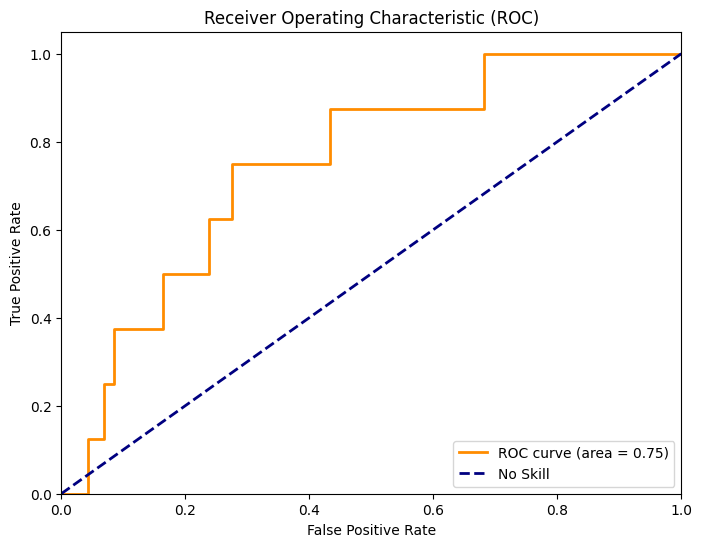

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Obtenemos los valores de la predicción a partir de las probabilidades
threshold = 0.15
y_pred = (y_pred_probs >= threshold).astype(int)

**Matriz de confusión**

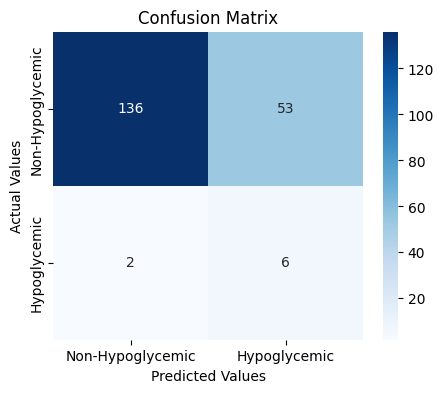

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                     columns = ['Non-Hypoglycemic', 'Hypoglycemic'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

**Resumen métricas**

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

report = classification_report(y_test, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)

f1_score = report['Hypoglycemic']['f1-score']
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_acuracy = balanced_accuracy_score(y_test, y_pred)

metrics = {
    'Accuracy': accuracy.round(2),
    'Sensitivity': sensitivity.round(2),
    'Specificity': specificity.round(2),
    'ROC AUC': roc_auc.round(2),
    'F1 Score (Hypoglycemia class)': round(f1_score,2),
    'MCC': mcc.round(2),
    'Balanced accuracy': balanced_acuracy,
    'Classification Report': report
}

metrics

{'Accuracy': 0.72,
 'Sensitivity': 0.75,
 'Specificity': 0.72,
 'ROC AUC': 0.75,
 'F1 Score (Hypoglycemia class)': 0.18,
 'MCC': 0.2,
 'Balanced accuracy': 0.7347883597883598,
 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.9855072463768116,
   'recall': 0.7195767195767195,
   'f1-score': 0.8318042813455658,
   'support': 189},
  'Hypoglycemic': {'precision': 0.1016949152542373,
   'recall': 0.75,
   'f1-score': 0.17910447761194032,
   'support': 8},
  'accuracy': 0.7208121827411168,
  'macro avg': {'precision': 0.5436010808155245,
   'recall': 0.7347883597883598,
   'f1-score': 0.505454379478753,
   'support': 197},
  'weighted avg': {'precision': 0.9496163902906158,
   'recall': 0.7208121827411168,
   'f1-score': 0.8052987055594288,
   'support': 197}}}